# UHK SMAP ovalek 01

In [56]:
# install packages
%pip install numpy pandas tensorflow tensorflow_datasets scikit-learn scipy matplotlib tensorflow_io

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [57]:
import numpy as np
import pandas as pd
import os
print(os.listdir("./data"))

['small', 'photos_sanitized.csv', 'parameters_products_color_sanitized.csv', 'tmp_dataset', 'result_01.txt', 'parameters_list_sanitized.csv', 'parameters_products_pattern_sanitized.csv', 'output_accuracy_01.png']


In [58]:
import tensorflow as tf
# check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Load data

In [59]:
import csv
import numpy as np
import os
import PIL
import PIL.Image

# load labels
label_ids = []
label_names = []
with open('./data/parameters_list_sanitized.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            line_count += 1
            if not row[0] in label_ids:
                label_ids += [row[0]]
                label_names += [row[2]]

# load product label relations
products_labels = {}
with open('./data/parameters_products_color_sanitized.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            line_count += 1
            if not row[0] in products_labels:
                products_labels[row[0]] = []
            for label_index, label_id in enumerate(label_ids):
                if label_id == row[2]:
                    products_labels[row[0]] += [label_names[label_index]]
with open('./data/parameters_products_pattern_sanitized.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            line_count += 1
            if not row[0] in products_labels:
                products_labels[row[0]] = []
            for label_index, label_id in enumerate(label_ids):
                if label_id == row[2]:
                    products_labels[row[0]] += [label_names[label_index]]

# load products with main photo
products = []
with open('./data/photos_sanitized.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            line_count += 1
            if row[4] != 'Y':
                continue
            found = False
            for product in products:
                if product[0] == row[0]:
                    found = True
                    break
            if not found:
                products += [(row[0], row[1], row[3], row[4], ), ]
    print(f'Processed {line_count} lines.')
    print(f'Found products {products.__len__}.')


Column names are id_product, id_photo, date_update, position, show_in_lead
Processed 16161 lines.
Found products <method-wrapper '__len__' of list object at 0x7fad08bacf80>.


In [60]:
import os
from os.path import exists
from PIL import Image
import imghdr

# prepare data for dataset
data_photos_paths = []
data_labels = []
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for product in products:
    tmp_path = f'./data/small/{int(product[0]) % 10}/{product[0]}/{product[0]}_{product[1]}_{product[3]}_{product[2]}_small.webp'
    tmp_path_jpg = f'./data/small/{int(product[0]) % 10}/{product[0]}/{product[0]}_{product[1]}_{product[3]}_{product[2]}_small.jpg'
    if not exists(tmp_path):
        continue
    if not exists(tmp_path_jpg) and os.stat(tmp_path).st_size == 0:
        print(f'Empty file: {tmp_path}')
        continue
    if not exists(tmp_path_jpg):
        im = Image.open(tmp_path).convert('RGB')
        im.save(tmp_path_jpg, "jpeg")

    img_type = imghdr.what(tmp_path_jpg)
    if img_type is None:
        print(f"{tmp_path_jpg} is not an image")
        continue

    data_photos_paths += [tmp_path_jpg]
    tmp_product_labels = products_labels[product[0]]
    tmp_labels_vector = []
    for label in label_names:
        tmp_labels_vector += [1 if label in tmp_product_labels else 0]
    data_labels += [tmp_labels_vector]
    # for label_index, label_name in enumerate(label_names):
    #     if label_name == tmp_product_labels[0]:
    #         data_labels += [label_index]
    #         break

# print(', '.join(data_labels[0]))

## Prepare train test and validation data

In [61]:
from sklearn.model_selection import train_test_split
import tensorflow_io as tfio

data_photos_paths_train, data_photos_paths_tmp, data_labels_train, data_labels_tmp = train_test_split(data_photos_paths, data_labels, test_size=0.25, random_state=42)
data_photos_paths_test, data_photos_paths_validation, data_labels_test, data_labels_validation = train_test_split(data_photos_paths_tmp, data_labels_tmp, test_size=0.4, random_state=None, shuffle=False)



def _create_dataset(X, y):
    X = tf.constant(X)
    y = tf.constant(y)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    def _prepare_picture_func(picturepath, labels):
        image_string = tf.io.read_file(picturepath)
        image = tf.image.decode_image(image_string, channels=3)
        # print(picturepath)
        # image = tfio.image.decode_webp(image_string)
        # image = image[:,:,:3] # discard alpha channel
        image.set_shape([None, None, None])
        image = tf.image.resize(image, [250, 340])
        # image = tf.subtract(image, 116.779) # Zero-center by mean pixel
        # # image.set_shape([200, 200, 3])
        # image.set_shape((250, 250, 3))
        image.set_shape((250, 340, 3))
        # image = image.reshape(-1, 250, 340, 3)
        # image = tf.reverse(image, axis=[2]) # 'RGB'->'BGR'
        # d = dict(zip([picturepath], [image])), labels
        # return (picturepath, image), labels
        return image, labels
        # return d
    return dataset.map(_prepare_picture_func)

train_ds = _create_dataset(data_photos_paths_train, data_labels_train)
test_ds = _create_dataset(data_photos_paths_test, data_labels_test)
validation_ds = _create_dataset(data_photos_paths_validation, data_labels_validation)

In [62]:
# train_batch = train_ds.batch(32)
# test_batch = test_ds.batch(32)

# # check batch
# for image_batch, labels_batch in train_batch:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break


## Create NN model

In [63]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
tf.compat.v1.enable_eager_execution()


# # Initializes a sequential model
# model = Sequential()

# # First layer (pictures are 240x340=85000 x 3 colors => 255000)
# # model.add(Dense(2048, activation='relu', input_shape=(255000, )))
# model.add(Dense(2048, activation='relu', input_shape=(250, 250, 3)))
# # model.add(Dense(2048, activation='relu', input_shape=(187500, )))
# # model.add(Dense(2048, activation='relu', input_dim=187500))

# # Second layer
# model.add(Dense(256, activation='relu'))

# # Output layer (multi-label classification therefore use sigmoid activation function)
# model.add(Dense(48, activation='sigmoid'))

# model.summary()


num_classes = len(label_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(250, 340, 3)),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(250, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  # layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  # layers.Dense(1)
])

## Compile NN

In [64]:
# multi-label classification therefore use binary_crossentropy
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 250, 340, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 250, 340, 250)     7000      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 125, 170, 250)    0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 170, 250)     562750    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 85, 250)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 85, 250)      

## Use NN for data

In [65]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# model.fit_generator(
#         train_batch, 
#         steps_per_epoch=len(train_batch), # batch_size
#         validation_data=test_batch,
#         validation_steps=len(test_batch), # batch_size
#         epochs=10,
#         callbacks=callbacks
#     )
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=validation_ds,
#   epochs=epochs
# )
epochs=10
history = model.fit(
  train_ds.batch(32),
  validation_data=validation_ds.batch(32),
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/10


2022-12-14 09:17:16.637855: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2720000000 exceeds 10% of free system memory.
2022-12-14 09:17:16.810147: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2720000000 exceeds 10% of free system memory.
2022-12-14 09:17:17.327851: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2720000000 exceeds 10% of free system memory.
2022-12-14 09:17:23.192850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1360000000 exceeds 10% of free system memory.
2022-12-14 09:17:23.192896: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2720000000 exceeds 10% of free system memory.


181/181 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.1959
Epoch 1: val_loss improved from inf to 0.12898, saving model to model.h5
181/181 [==============================] - 1640s 9s/step - loss: 0.1591 - accuracy: 0.1959 - val_loss: 0.1290 - val_accuracy: 0.2228 - lr: 0.0010
Epoch 2/10
181/181 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.1930
Epoch 2: val_loss improved from 0.12898 to 0.12794, saving model to model.h5
181/181 [==============================] - 1632s 9s/step - loss: 0.1279 - accuracy: 0.1930 - val_loss: 0.1279 - val_accuracy: 0.2228 - lr: 0.0010
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.1935
Epoch 3: val_loss improved from 0.12794 to 0.12779, saving model to model.h5
181/181 [==============================] - 1642s 9s/step - loss: 0.1275 - accuracy: 0.1935 - val_loss: 0.1278 - val_accuracy: 0.2228 - lr: 0.0010
Epoch 4/10
181/181 [==============================] - ETA:

## Visualize training

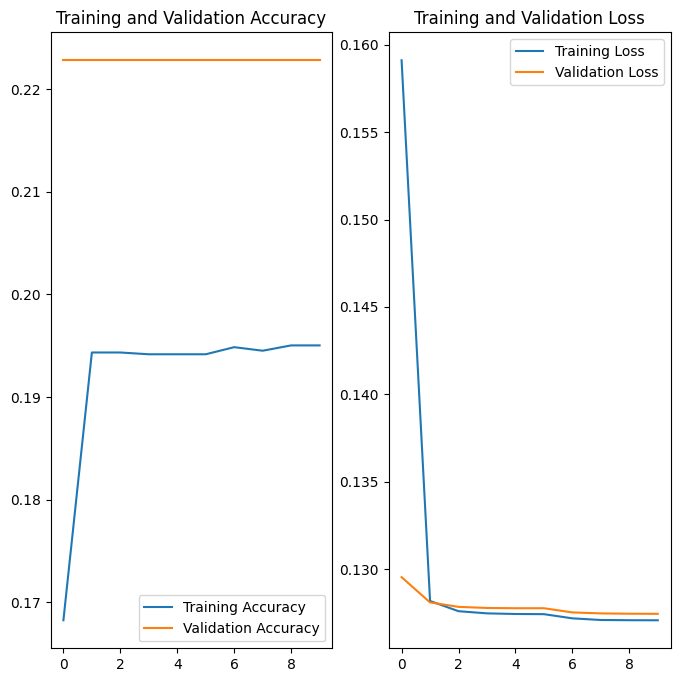

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Try prediction

In [ ]:
# from PIL import Image

# Image.open(data_photos_paths_validation[0])
# # PIL.Image.open(str(data_photos_paths_validation[0]))
# print('Expected: ', data_labels_validation[0])
# print('Predicted: ', model.predict(data_photos_paths_validation[0]))

Expected:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


IndexError: tuple index out of range